# Kolmogorov-Smirnov test

During Model Validation this criterion shows to what extent the model separates the actual good borrowers from the actual bad borrowers.

It is measured by looking at the cumulative distributions of actual bad borrowers and actual good borrowers with respect to the estimated probabilities of being good and bad by our model. 

**KS for this case is the maximum difference between the cumulative distribution functions of bad and good borrowers with respect to predicted probabilities.**

$$ KS =  max \Big\{(\text{Cumulative % Event}) - (\text{Cumulative % Non-Event})\Big\}  $$

where Event ($Y = 1$) = Default (ie. 'Bad' Borrowers) and Non-event ($Y = 0$) = Non-Default ('Good' Borrowers)
### Method:
- You need to have two variables before calculating KS. One is the binary dependent variable. Second is predicted probability score which is generated from statistical model.
- Sort the variables by the predicted probability score.
- Calculate the cumulative % of actual 'bad' and 'good' borrowers (default/non-default) then compute the difference between these two cumulative distributions.
- KS is where the difference is maximum

The greater this difference the better the model.

Perfect model -> Maximum distance KS = 1, Predicting by chance -> Almost no distance KS = 0


In order to perform Model Performance Monitoring, KS-test can be used to measure the predictive power of the scorecard on the Recent population and compares this performance to that of Development population.

<p class='lead'> Code Example using the LoanEE2 Dataset: </p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/ProtectedFeaturesLoanEE2.csv')

#### Select favourable and unfavourable outcome

In [3]:
target='Default'

#### Fill in missing values in the dataset

In [4]:
data['MonthlyPayment'].fillna((data['MonthlyPayment'].mean()), inplace=True)
data['ExpectedLoss'].fillna((data['ExpectedLoss'].mean()), inplace=True)
data['ProbabilityOfDefault'].fillna((data['ProbabilityOfDefault'].mean()), inplace=True)
data['DebtToIncome'].fillna((data['DebtToIncome'].mean()), inplace=True)
data['FreeCash'].fillna((data['FreeCash'].mean()), inplace=True)
data['LossGivenDefault'].fillna(0, inplace=True)

In [5]:
x=data.drop(columns=['Young','Unnamed: 0', 'Unnamed: 0.1', 'Default'])
y=data['Default']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=6666)

In [7]:
logistic_reg = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)

In [8]:
y_pred = logistic_reg.predict(X_test)
y_pred_prob = logistic_reg.predict_proba(X_test)[:,0]

In [9]:
print("Accuracy of the model:", logistic_reg.score(X_test, y_test))

Accuracy of the model: 0.7589824427895853


## P-values with Logistic Regression

### Significance/Hypothesis Testing 

#### Null Hyposthesis Significance Testing (NHST)
A statistical hypothesis is an assumption about a population which may or may not be true. Hypothesis testing is a set of formal procedures used by statisticians to either accept or reject statistical hypotheses. Statistical hypotheses are of two types: 

eg: if we have a hypothesis that people with gene X - eat a different amount of calories..

- **Null Hypothesis (H_0)**: says that this gene has no difference or effect 

- **Alternate Hypothesis (H_a)**: agrees with our original hypothesis

P-value: probability value 

In a nut-shell p-values indicate how "rare" your data is by telling you the probability of getting data that's as extreme as the data you observed if the null hypothesis were true. Typically p-values depict the two-sided tails of a distribution. This allows us to reject our null hypothesis if our value is signifacntly higher or lower than the mean. 

*ONE COMMON MISCONCEPTION of a p-value is that it can tell you the probability that the null hypothesis is true* **IT CAN'T!!**

**Conventionally if a p-value is lower than 0.05 five we conclude that the coefficient of that variable is *statistically significant.***

Computing [p-values](http://rspeare.blogspot.com/2017/10/p-values-for-logistic-regression.html) for each and every coefficient fit by a sklearn logistic regression model - boils down to computing the Log-likelihood $\mathcal{L}$, the Fisher Information Matrix $F$ and the Cramer-Rao bound. 

$$ \frac{-\partial^2\mathcal{L}}{\partial\beta_i\partial\beta_j} = F_{ij} $$
$$ Var[\beta_i] \geq F_{ii}^{-1} $$

Which for logistic regression, gives us:

$$ P(y|x) = \frac{1}{1 + e^{-\beta.x}} $$

$$ \mathcal{L} = \sum^{N}_{n=1} y_n log(P(y_n|x_n)) + (1-y_n)log(1-P(y_n|x_n))$$

$$ F_{ij} = \sum^N_{n=1} \frac{x_{ni}x_{nj}}{2 + 2 cosh(\beta.x)} $$ (*no idea how to prove $F_{ij}$*)

```decision_function(X)``` refers to $\beta.x$

> ```sklearn``` Predict confidence scores for samples.
The confidence score for a sample is the signed distance of that sample to the hyperplane.


Normally one assumes each $\beta$ coefficient is normally distributed, with mean $\hat{\beta}$ -- the maximum likelihood estimate, which in the case of logistic regression is wherever you stop numerically since there is no analytical solution.

Variance: $ \sigma_{\beta_i} \approx F_{ii}^{-1}$

Coefficient: $ \beta \sim \mathcal{N}(\hat{\beta_i}, F_{ii}^{-1})$ 

In [10]:
# P values for sklearn logistic regression.
# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        noisy_F_ij = F_ij+0.00001*np.random.rand(F_ij.shape[0],F_ij.shape[1])
        Cramer_Rao = np.linalg.inv(noisy_F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for each model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [11]:
logistic_reg_p = LogisticRegression_with_p_values()

In [12]:
logistic_reg_p.fit(X_train, y_train)

In [13]:
feature_name = X_train.columns.values
summary_table_p = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table_p['Coefficients'] = np.transpose(logistic_reg_p.coef_)
summary_table_p.index = summary_table_p.index + 1
summary_table_p.loc[0] = ['Intercept', logistic_reg_p.intercept_[0]]
summary_table_p = summary_table_p.sort_index()

In [14]:
p_values = logistic_reg_p.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table_p['p_values'] = p_values
summary_table_p['p_values'] = summary_table_p['p_values'].round(decimals=5)

#### Statistically significant features
Now we can select independent variables based on them by only retaining the variables with coefficients that are statistically significant.

It's good to remember that each original independent variable is represented by several dummy variables. If two or more of the dummy variables representing one original independent variable are statistically significant it would be best to retain all dummy variables that represent that original independent variable in the final model.

**Conventionally if a p-value is lower than 0.05 five we conclude that the coefficient of that variable is *statistically significant.***

In [15]:
summary_table_p[summary_table_p['p_values'] < 0.05]

,Feature name,Coefficients,p_values
2,AppliedAmount,0.000229,0.00000
6,FreeCash,-0.000234,0.00025
7,IncomeFromChildSupport,0.001838,0.00000
8,IncomeFromFamilyAllowance,0.001853,0.00000
9,IncomeFromLeavePay,0.001297,0.00000
10,IncomeFromPension,0.000495,0.03505
11,IncomeFromPrincipalEmployer,0.000884,0.00000
12,IncomeFromSocialWelfare,0.002019,0.00090
13,IncomeOther,0.000887,0.00000
14,IncomeTotal,-0.000888,0.00000


In [16]:
print("Accuracy of the model:", logistic_reg_p.model.score(X_test, y_test)) #should be the same as previous logistic regression

Accuracy of the model: 0.7589824427895853


In [17]:
df_actual_predicted_probs = pd.DataFrame({'y_test':y_test, 'y_hat_test_proba':y_pred_prob})

In [18]:
tr = 0.5 
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)

In [19]:
df_actual_predicted_probs = df_actual_predicted_probs.sort_values('y_hat_test_proba')

In [20]:
df_actual_predicted_probs = df_actual_predicted_probs.reset_index()

### Calculate cumulative number of all observations, of 'bad' and 'good' borrowers

In [21]:
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in python starts from 0, we add 1 to each index.
df_actual_predicted_probs['Cumulative N Population'] = df_actual_predicted_probs.index + 1

# We calculate cumulative number of 'bad', which is the cumulative sum of the column with actual observations.
df_actual_predicted_probs['Cumulative N Bad'] = df_actual_predicted_probs['y_test'].cumsum()

# We calculate cumulative number of 'good', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.
df_actual_predicted_probs['Cumulative N Good'] = df_actual_predicted_probs['Cumulative N Population'] - df_actual_predicted_probs['y_test'].cumsum()

In [22]:
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Bad,Cumulative N Good
0,4740,0,0.111078,0,1,0,1
1,3712,0,0.159244,0,2,0,2
2,3617,0,0.162393,0,3,0,3
3,6821,0,0.181421,0,4,0,4
4,6649,1,0.182868,0,5,1,4


### Calculate cumulative % of all observations, of 'bad' and 'good' borrowers

In [23]:
# We calculate the cumulative percentage of all observations.
df_actual_predicted_probs['Cumulative Perc Population'] = df_actual_predicted_probs['Cumulative N Population'] / (df_actual_predicted_probs.shape[0])

# We calculate cumulative percentage of 'bad'.
df_actual_predicted_probs['Cumulative Perc Bad'] = df_actual_predicted_probs['Cumulative N Bad'] / df_actual_predicted_probs['y_test'].sum()

# We calculate the cumulative percentage of 'good'.
df_actual_predicted_probs['Cumulative Perc Good'] = df_actual_predicted_probs['Cumulative N Good'] / (df_actual_predicted_probs.shape[0] - df_actual_predicted_probs['y_test'].sum())

In [24]:
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good
0,4740,0,0.111078,0,1,0,1,0.000054,0.000000,0.000071
1,3712,0,0.159244,0,2,0,2,0.000109,0.000000,0.000143
2,3617,0,0.162393,0,3,0,3,0.000163,0.000000,0.000214
3,6821,0,0.181421,0,4,0,4,0.000217,0.000000,0.000286
4,6649,1,0.182868,0,5,1,4,0.000272,0.000227,0.000286


## Calculate Kolmogorov-Smirnov coefficient (KS)

**KS for this case is the maximum difference between the cumulative distribution functions of bad and good borrowers with respect to predicted probabilities.**

The greater this difference the better the model.

Perfect model -> Maximum distance KS = 1, Predicting by chance -> Almost no distance KS = 0

In [25]:
df_actual_predicted_probs['Individual KS'] = abs(df_actual_predicted_probs['Cumulative Perc Bad'] - df_actual_predicted_probs['Cumulative Perc Good'])

In [26]:
df_actual_predicted_probs.head()

,index,y_test,y_hat_test_proba,y_hat_test,Cumulative N Population,Cumulative N Bad,Cumulative N Good,Cumulative Perc Population,Cumulative Perc Bad,Cumulative Perc Good,Individual KS
0,4740,0,0.111078,0,1,0,1,0.000054,0.000000,0.000071,0.000071
1,3712,0,0.159244,0,2,0,2,0.000109,0.000000,0.000143,0.000143
2,3617,0,0.162393,0,3,0,3,0.000163,0.000000,0.000214,0.000214
3,6821,0,0.181421,0,4,0,4,0.000217,0.000000,0.000286,0.000286
4,6649,1,0.182868,0,5,1,4,0.000272,0.000227,0.000286,0.000059


Text(0.5, 1.0, 'Kolmogorov-Smirnov')

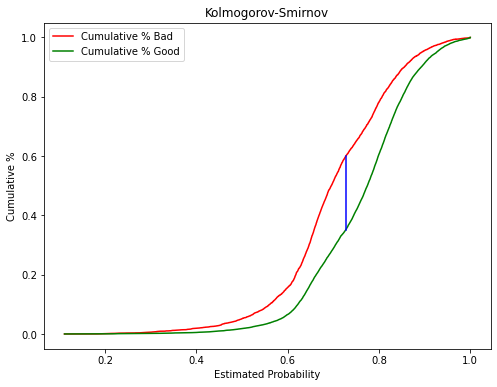

In [27]:
# Plot KS
fig = plt.figure(figsize=(8,6))
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Bad'], color = 'r', label='Cumulative % Bad')
plt.plot(df_actual_predicted_probs['y_hat_test_proba'], df_actual_predicted_probs['Cumulative Perc Good'], color = 'g', label='Cumulative % Good')

x = df_actual_predicted_probs['y_hat_test_proba']
    
y1 = df_actual_predicted_probs['Cumulative Perc Bad']
y2 = df_actual_predicted_probs['Cumulative Perc Good']
    
ind_max = np.argmax((y1-y2)**2)

# plt.axvline(x[ind_max], color="blue", linestyle="dashed", alpha=0.4)
plt.plot([x[ind_max], x[ind_max]], [y2[ind_max], y1[ind_max]], color="blue")

plt.xlabel('Estimated Probability')
plt.ylabel('Cumulative %')
plt.legend()
plt.title('Kolmogorov-Smirnov')

We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
and the cumulative percentage of 'good'.

In [28]:
KS = max(df_actual_predicted_probs['Individual KS'])
KS

0.24890443314778865

## KS test function

In [29]:
def ks_test(y_actual, y_pred_prob, classifier_threshold):
    df_actual_pred_probs = pd.DataFrame({'y_actual':y_actual, 'y_hat_test_proba':y_pred_prob})
    df_actual_pred_probs['y_hat_test'] = np.where(df_actual_pred_probs['y_hat_test_proba'] > tr, 1, 0)
    df_actual_pred_probs = df_actual_pred_probs.sort_values('y_hat_test_proba')
    df_actual_pred_probs = df_actual_pred_probs.reset_index()
    
    df_actual_pred_probs['Cumulative N Population'] = df_actual_pred_probs.index + 1
    df_actual_pred_probs['Cumulative N Bad'] = df_actual_pred_probs['y_actual'].cumsum()
    df_actual_pred_probs['Cumulative N Good'] = df_actual_pred_probs['Cumulative N Population'] - df_actual_pred_probs['y_actual'].cumsum()

    df_actual_pred_probs['Cumulative Perc Population'] = df_actual_pred_probs['Cumulative N Population'] / (df_actual_pred_probs.shape[0])
    df_actual_pred_probs['Cumulative Perc Bad'] = df_actual_pred_probs['Cumulative N Bad'] / df_actual_pred_probs['y_actual'].sum()
    df_actual_pred_probs['Cumulative Perc Good'] = df_actual_pred_probs['Cumulative N Good'] / (df_actual_pred_probs.shape[0] - df_actual_pred_probs['y_actual'].sum())

    KS = max(df_actual_pred_probs['Cumulative Perc Bad'] - df_actual_pred_probs['Cumulative Perc Good'])
    
    return KS


#### KS coefficient on the test data 

In [30]:
ks_test(y_test, y_pred_prob, 0.5)

0.24890443314778865

#### KS coefficient on the train data 

In [31]:
y_pred_prob_train = logistic_reg.predict_proba(X_train)[:,0]

In [32]:
ks_test(y_train, y_pred_prob_train, 0.5)

0.2532086600268418

In [33]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

     #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)